### Learning Pandas

# New York Airbnb

Clean and analyze Airbnb listings data in New York for 2019.

---

## Introduction

### Importing libraries & Reading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
airbnb_df = pd.read_csv('data/airbnb_data.csv')

airbnb_df.head()

,listing_id,listing_name,host_id,host_name,neighbourhood_group,lat_lon,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,"Kensington, Brooklyn",40.64749;-73.97237,Private room,"$149,00.-",1,9,19/10/18,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,"Midtown, Manhattan",40.75362;-73.98377,Entire home/apt,"$225,00.-",1,45,21/5/19,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,"Harlem, Manhattan",40.80902;-73.9419,Private room,"$150,00.-",3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,"Clinton Hill, Brooklyn",40.68514;-73.95976,Entire home/apt,"$89,00.-",1,270,5/7/19,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,"East Harlem, Manhattan",40.79851;-73.94399,Entire home/apt,"$80,00.-",10,9,19/11/18,0.10,1,0


### Setting index

* Set `listing_id` column as the index of the dataframe:

In [3]:
airbnb_df.set_index('listing_id', inplace=True)

---

## Cleaning data

### Fixing data types

* Change `last_review` column to `datetime`:

In [4]:
airbnb_df['last_review'] = pd.to_datetime(airbnb_df['last_review'])

### Fixing missing data

* List of columns that have missing values:

In [5]:
columns = airbnb_df.isna().sum()
columns[airbnb_df.isna().sum() > 0]

host_name             1
last_review          43
reviews_per_month    43
dtype: int64

* Replace `reviews_per_month` missing values with `0`:

In [6]:
airbnb_df['reviews_per_month'].fillna(0, inplace=True)

* Drop the rows where `host_name` has a missing value:

In [7]:
# alt solution: airbnb_df = airbnb_df.loc[airbnb_df['host_name'].notna()]

airbnb_df = airbnb_df.dropna(subset=['host_name'])

* Drop the rows where `last_review` has a missing value:

In [8]:
# alt solution: airbnb_df = airbnb_df.loc[airbnb_df['last_review'].notna()]

airbnb_df = airbnb_df.dropna(subset=['last_review'])

### Fixing invalid values

* Drop the rows where `host_id` has a `0` value:

In [9]:
# alt solution: airbnb_df = airbnb_df.loc[airbnb_df['host_id'] != 0]

airbnb_df.drop(index=airbnb_df.loc[airbnb_df['host_id'] == 0].index, inplace=True)

* Fix `price`column:
    * Remove the `$`, `.` and `-` characters.
    * Replace `,` with a `.` character.
    * Cast the column to `float` dtype.

In [10]:
airbnb_df['price'] = airbnb_df['price'].str.replace('$', '')
airbnb_df['price'] = airbnb_df['price'].str.replace('.-', '')
airbnb_df['price'] = airbnb_df['price'].str.replace(',', '.')
airbnb_df['price'] = airbnb_df['price'].astype('float')

<ipython-input-10-cd74124c6c50>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  airbnb_df['price'] = airbnb_df['price'].str.replace('$', '')
<ipython-input-10-cd74124c6c50>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  airbnb_df['price'] = airbnb_df['price'].str.replace('.-', '')


* Fixing `availability_365` column:

    * Cast this columns to numeric dtype, `coerce` invalid string values.
    * Convert negative numbers to positive.
    * Drop numbers above 365.

In [11]:
airbnb_df['availability_365'] = pd.to_numeric(airbnb_df['availability_365'], errors='coerce')

airbnb_df['availability_365'] = airbnb_df['availability_365'].abs()

airbnb_df = airbnb_df.loc[airbnb_df['availability_365'] <= 365]

In [12]:
airbnb_df['availability_365'].unique()

array([365., 355., 194.,   0., 129., 220., 188.,   6.,  39., 314.,  46.,
       321.,  12.,  21., 304., 347., 364., 233.,  85.,  75., 311.,  67.,
       255., 284., 359., 269., 340.,  22.,  96., 345., 273.,  95., 215.,
       265., 192., 251., 302., 140., 234., 257.,  30., 301., 294., 320.,
       154., 180., 231., 297., 292., 191.,  72., 362., 336., 116.,  88.,
       224., 322., 324., 132., 295., 238., 209., 328.,   7., 272.,  26.,
       288., 317., 207., 185., 158.,   9., 198., 219., 342., 312., 243.,
       152., 137., 222., 346., 208., 279., 250., 164., 298., 260., 107.,
       199., 299.,  20., 318., 216., 245., 189., 307., 310., 213., 278.,
        16., 178., 275., 163.,  34., 280.,   1., 170., 214., 248., 262.,
       339.,  10., 290., 230.,  53., 126.,   3.,  37., 353., 177., 246.,
       225.,  18., 343., 326., 162., 240., 363., 247., 323., 125.,  91.,
       286.,  60.,  58., 351., 201., 232., 258., 341., 244., 329., 253.,
       348., 153.,   2.,  56.,  68., 360.,  76.,  1

### Duplicated listings

* Drop all the entries that have the same `listing_name`, `price` and `room_type`, keep the `last` entry:

In [13]:
airbnb_df.drop_duplicates(subset=['listing_name', 'price', 'room_type'],
                          keep='last',
                          inplace=True)

### Separating columns

* Separate the `neighbourhood_group` column into two different columns `neighbourhood` and `borough` and drop it:

In [14]:
airbnb_df[['neighbourhood', 'borough']] = airbnb_df['neighbourhood_group'].str.split(', ', expand=True)

airbnb_df.drop(columns='neighbourhood_group', inplace=True)

* Separate the `lat_lon` column into two new columns `latitude` and `longitude` and drop it. Then cast two new columns to `float` dtype:

In [15]:
airbnb_df[['latitude', 'longitude']] = airbnb_df['lat_lon'].str.split(';', expand=True)

airbnb_df.drop(columns='lat_lon', inplace=True)

airbnb_df = airbnb_df.astype({'latitude': 'float',
                              'longitude': 'float'})

## Analyzing  data

### Most reviews

* Create a Series `most_reviews` containing the top 10 `host_name`s with the most total (sum) reviews per month accross all properties owned by that host:

In [16]:
most_reviews = airbnb_df['reviews_per_month'].groupby(airbnb_df['host_name']).sum().sort_values(ascending=False).head(10)

* Visualizing `most_reviews`:

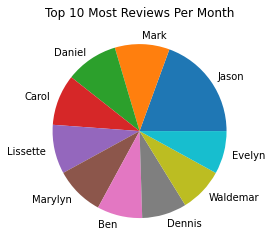

In [17]:
most_reviews.plot(kind='pie')

plt.title("Top 10 Most Reviews Per Month")
plt.ylabel("");

### Most expensive listings

* Create a variable `expensive_listings_df` containing the top 10 most expensive per night listings:

In [18]:
expensive_listings_df = airbnb_df.sort_values(by='price', ascending=False).head(10)

expensive_listings_df

,listing_name,host_id,host_name,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood,borough,latitude,longitude
listing_id,,,,,,,,,,,,,,,
174966,Luxury 2Bed/2.5Bath Central Park View,836168,Henry,Entire home/apt,2000.0,30,30,2018-05-05,0.33,11,0.0,Upper West Side,Manhattan,40.77350,-73.98697
273190,6 Bedroom Landmark West Village Townhouse,605463,West Village,Entire home/apt,1300.0,5,28,2018-09-25,0.31,4,297.0,West Village,Manhattan,40.73301,-74.00268
250801,Heart & Soul of Greenwich Village,1314834,Rhona,Entire home/apt,850.0,3,107,2019-05-23,1.15,1,249.0,Greenwich Village,Manhattan,40.73129,-73.99944
279857,#1 Yellow Block BnB/see at Net Flix Show Stay ...,1420300,Gordy,Entire home/apt,800.0,4,122,2019-02-07,1.37,1,257.0,Bedford-Stuyvesant,Brooklyn,40.68492,-73.95489
19601,perfect for a family or small group,74303,Maggie,Entire home/apt,800.0,1,25,2016-04-08,0.24,1,7.0,Brooklyn Heights,Brooklyn,40.69723,-73.99268
256328,Luxury Chelsea Townhouse at the High Line,1347034,Janine,Entire home/apt,760.0,2,7,2019-06-22,0.08,1,361.0,Chelsea,Manhattan,40.74599,-74.00253
248871,4 BEDROOM -2BATHRM WEST VILLAGE DUPLEX TOWNHOUSE,605463,West Village,Entire home/apt,700.0,3,131,2019-06-24,1.40,4,296.0,West Village,Manhattan,40.73066,-74.00287
103311,2 BR w/ Terrace @ Box House Hotel,417504,The Box House Hotel,Private room,599.0,3,9,2018-05-19,0.09,28,60.0,Greenpoint,Brooklyn,40.73861,-73.95485
254168,2 BR Duplex @ Box House Hotel,417504,The Box House Hotel,Private room,599.0,3,7,2018-11-16,0.08,28,60.0,Greenpoint,Brooklyn,40.73793,-73.95316


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### Which neighbourhood has biggest amount of expensive listings?

* Using the `expensive_listings_df` listings count the occurrences of each `neighbourhood` they belong:

In [19]:
expensive_listings_df['neighbourhood'].value_counts()

Greenpoint            2
West Village          2
Little Italy          1
Bedford-Stuyvesant    1
Brooklyn Heights      1
Chelsea               1
Upper West Side       1
Greenwich Village     1
Name: neighbourhood, dtype: int64

* Visualizing `neighbourhood`:

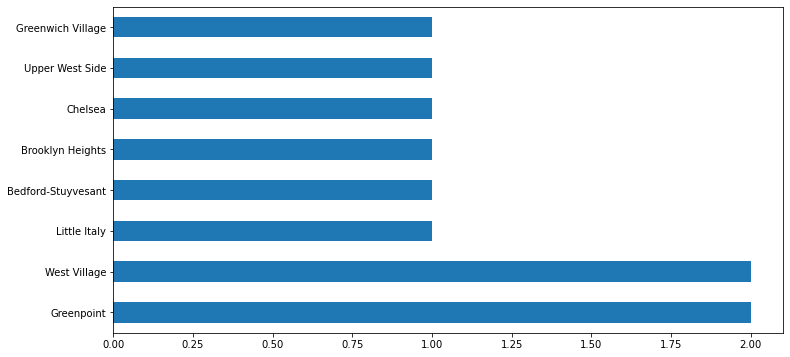

In [20]:
expensive_listings_df['neighbourhood'].value_counts().plot(kind='barh',
                                                           figsize=(12,6));

### Which neighbourhood has the most listings?

* Using all the listings from `airbnb_df` to show top 10 neighbourhoods with the most listings:

In [21]:
airbnb_df['neighbourhood'].value_counts().head(10)

Williamsburg          110
Harlem                 74
Bedford-Stuyvesant     72
East Village           65
Upper West Side        44
Greenpoint             42
West Village           33
Crown Heights          32
Hell's Kitchen         30
Park Slope             27
Name: neighbourhood, dtype: int64

* Visualizing `neighbourhood`:

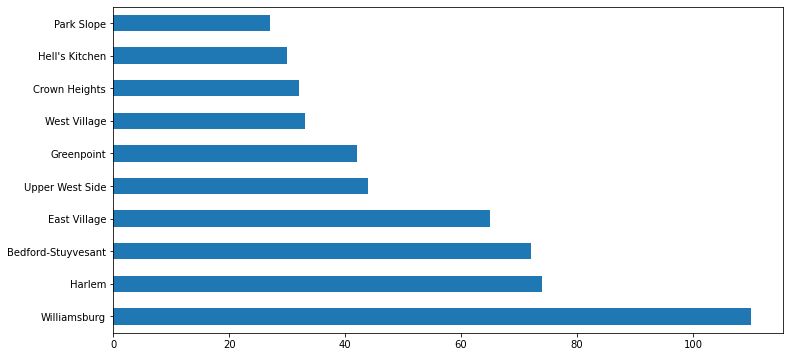

In [22]:
airbnb_df['neighbourhood'].value_counts().head(10).plot(kind='barh', 
                                                        figsize=(12,6));

### Visualizing all the listings on the New York City map

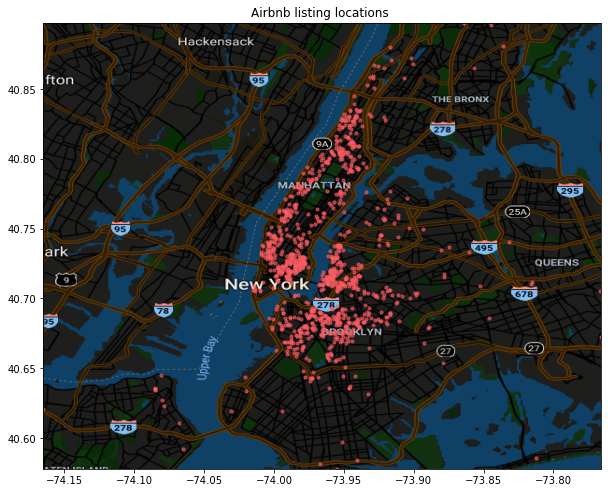

In [23]:
longlat_min_max = (airbnb_df.longitude.min(), airbnb_df.longitude.max(), airbnb_df.latitude.min(), airbnb_df.latitude.max())

nyc = plt.imread('./data/nyc-map.png')

fig, ax = plt.subplots(figsize=(10,9))

ax.scatter(airbnb_df.longitude, airbnb_df.latitude, zorder=1, alpha=0.6, c='#fd5c63', s=10)
ax.set_title('Airbnb listing locations ')
ax.imshow(nyc, extent=longlat_min_max);